# LTV Model Example Notebook

**Source:** [https://github.com/finlytics-hub/LTV_predictions](https://github.com/finlytics-hub/LTV_predictions)

http://brucehardie.com/papers/018/fader_et_al_mksc_05.pdf

http://brucehardie.com/notes/004/bgnbd_spreadsheet_note.pdf

## Prepare Notebook

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import *
from lifetimes.utils import (
    calculate_alive_path,
    calibration_and_holdout_data,
    summary_data_from_transaction_data
)
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read Data

In [2]:
data_path = "../data/OnlineRetail_2yrs.csv"

raw_data_df = pd.read_csv(data_path)

In [3]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981331 entries, 0 to 981330
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      981330 non-null  object 
 1   StockCode    981330 non-null  object 
 2   Description  976948 non-null  object 
 3   Quantity     981330 non-null  float64
 4   InvoiceDate  981330 non-null  object 
 5   Price        981330 non-null  float64
 6   Customer ID  741301 non-null  float64
 7   Country      981330 non-null  object 
dtypes: float64(3), object(5)
memory usage: 59.9+ MB


## Prepare Data

In [4]:
data_df = raw_data_df.copy()

data_df.columns = data_df.columns.str.lower().str.replace(" ", "_")

data_df = data_df \
    .drop(["country", "description"], axis=1) \
    .dropna(axis=0, subset=["customer_id"]) \
    .query("quantity > 0") \
    .assign(
        invoicedate=lambda x: pd.to_datetime(x["invoicedate"]).dt.round('D'),
        sales = lambda x: x['price'] * x['quantity']
    )

data_df = data_df[["customer_id", "invoicedate", "sales"]]

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 725296 entries, 0 to 981330
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  725296 non-null  float64       
 1   invoicedate  725296 non-null  datetime64[ns]
 2   sales        725296 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 22.1 MB


In [5]:
data_summary = summary_data_from_transaction_data(
    transactions=data_df,
    customer_id_col="customer_id",
    datetime_col="invoicedate",
    monetary_value_col="sales",
    freq="D"
)

data_summary.query("frequency > 0 ", inplace=True)

data_summary.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3818 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   frequency       3818 non-null   float64
 1   recency         3818 non-null   float64
 2   T               3818 non-null   float64
 3   monetary_value  3818 non-null   float64
dtypes: float64(4)
memory usage: 149.1 KB


In [6]:
data_summary.head()

,frequency,recency,T,monetary_value
customer_id,,,,
12346.0,7.0,400.0,727.0,11066.637143
12745.0,1.0,146.0,575.0,266.930000
12747.0,25.0,858.0,881.0,355.835600
12748.0,209.0,967.0,972.0,269.753541
12749.0,6.0,555.0,578.0,1020.433333


## BG/NBD Mode

In [7]:
# Fir BG/NBG model,
bgf = BetaGeoFitter()
bgf.fit(
    frequency=data_summary["frequency"],
    recency=data_summary["recency"],
    T=data_summary["T"]
)

bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.717243,0.050061,1.619123,1.815362
alpha,141.720196,4.574486,132.754203,150.686190
a,0.076706,0.009506,0.058074,0.095337
b,0.910547,0.150342,0.615878,1.205217


---

In [8]:
# https://sidravi1.github.io/blog/2018/07/08/fader-hardie-clv
import arviz as az
import pymc3 as pm
import theano.tensor as tt


n_vals = data_summary.shape[0]
x = data_summary["frequency"].to_numpy()
t_x = data_summary["recency"].to_numpy()
T = data_summary["T"].to_numpy()

int_vec = np.vectorize(int)
x_zero = int_vec(x > 0)


with pm.Model() as model_1:

    # Hypers for Gamma params    
    a = pm.HalfCauchy("a", 4)
    b = pm.HalfCauchy("b", 4)

    # Hypers for Beta params  
    alpha = pm.HalfCauchy("alpha", 4)
    r = pm.HalfCauchy("r", 4)

    lam = pm.Gamma("lam", r, alpha, shape=n_vals)
    p = pm.Beta("p", a, b, shape=n_vals)

    def logp(x, t_x, T, x_zero):

        log_termA = x * tt.log(1 - p) + x * tt.log(lam) - t_x * lam

        termB_1 = -lam * (T - t_x)
        termB_2 = tt.log(p) - tt.log(1 - p)

        log_termB = pm.math.switch(x_zero, pm.math.logaddexp(termB_1, termB_2), termB_1)

        return tt.sum(log_termA) + tt.sum(log_termB)

    likelihood = pm.DensityDist("likelihood", logp, observed = {"x":x, "t_x":t_x, "T":T, "x_zero":x_zero})


In [34]:
import arviz as az
import pymc3 as pm
import theano.tensor as tt


n_vals = data_summary.shape[0]
x = data_summary["frequency"].to_numpy()
t_x = data_summary["recency"].to_numpy()
T = data_summary["T"].to_numpy()

int_vec = np.vectorize(int)
x_zero = int_vec(x > 0)


with pm.Model() as model:

    # Hypers for Gamma params    
    a = pm.HalfCauchy("a", 4)
    b = pm.HalfCauchy("b", 4)

    # Hypers for Beta params  
    alpha = pm.HalfCauchy("alpha", 4)
    r = pm.HalfCauchy("r", 4)

    def logp(x, t_x, T, x_zero):
        a1 = tt.gammaln(r + x) - tt.gammaln(r) + r * tt.log(alpha)
        a2 = tt.gammaln(a + b) + tt.gammaln(b + x) - tt.gammaln(b) - tt.gammaln(a + b + x)
        a3 = -(r + x) * tt.log(alpha + T)
        a4 =  tt.log(a) - tt.log(b + tt.maximum(x, 1) - 1) - (r + x) * tt.log(t_x + alpha)
        max_a3_a4 = tt.maximum(a3, a4)
        ll_1 = a1 + a2 
        ll_2 = tt.log(tt.exp(a3 - max_a3_a4) + tt.exp(a4 - max_a3_a4) * pm.math.switch(x_zero, 1, 0)) + max_a3_a4
        return tt.sum(ll_1 + ll_2)

    likelihood = pm.DensityDist(
        name="likelihood",
        logp=logp,
        observed = {"x":x, "t_x":t_x, "T":T, "x_zero":x_zero}
    )

In [35]:
with model:
    trace = pm.sample(
        tune=2000,
        draws=4000,
        chains=4,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [r, alpha, b, a]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 91 seconds.


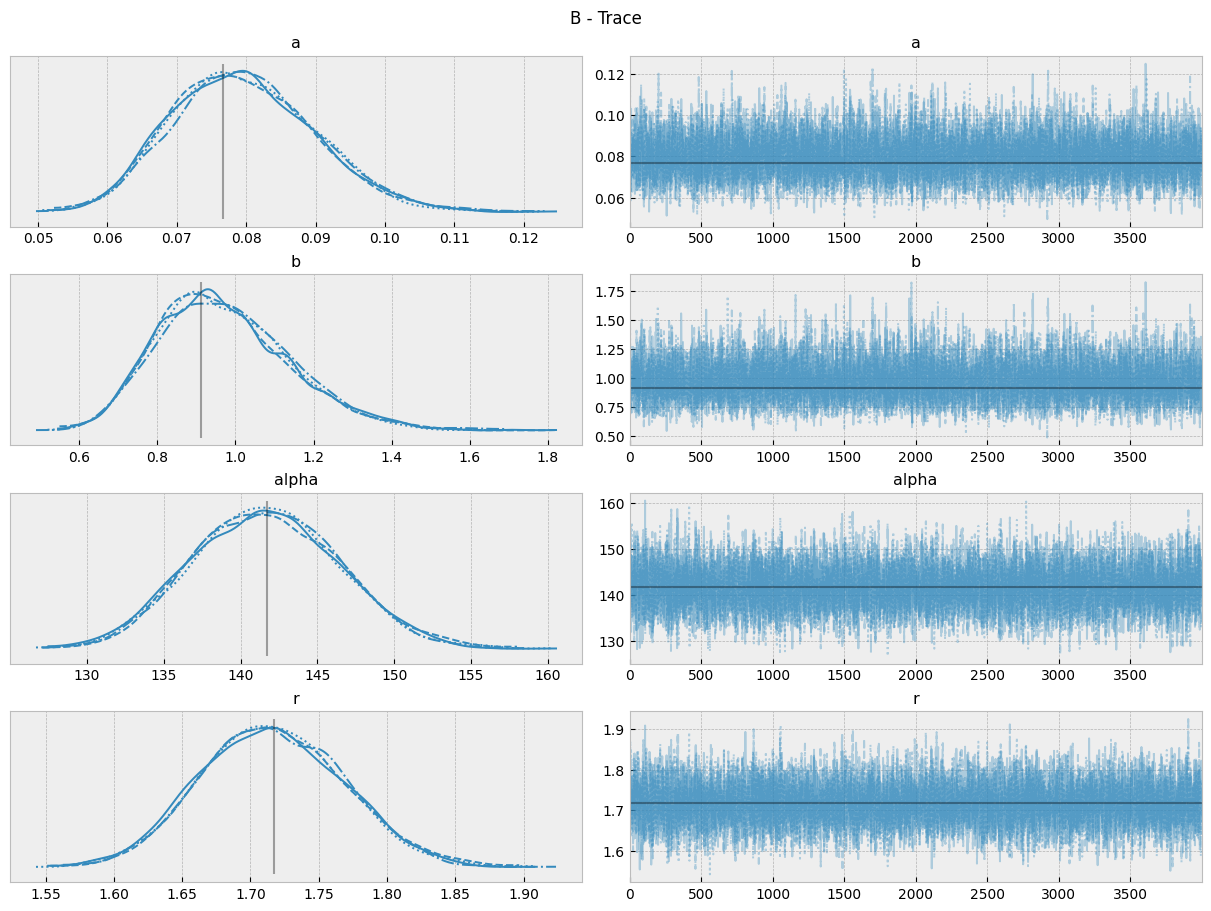

In [36]:
axes = az.plot_trace(
    data=trace,
    lines=[(k, {}, [v]) for k, v in bgf.summary["coef"].items()],
    compact=True,
    backend_kwargs={
        "figsize": (12, 9),
        "layout": "constrained"
    },
)
fig = axes[0][0].get_figure()
fig.suptitle("B - Trace");

In [85]:
from scipy.special import expit

def _sample(array, n_samples):
    """Little utility function, sample n_samples with replacement."""
    idx = np.random.choice(np.arange(len(array)), n_samples, replace=True)
    return array[idx]


def conditional_probability_alive(trace, x, t_x, T):

    n_vals = x.shape[0]

    a = _sample(array=trace.posterior["a"].to_numpy(), n_samples=n_vals)
    b = _sample(array=trace.posterior["b"].to_numpy(), n_samples=n_vals)
    alpha = _sample(array=trace.posterior["alpha"].to_numpy(), n_samples=n_vals)
    r = _sample(array=trace.posterior["r"].to_numpy(), n_samples=n_vals)


    log_div = (
        (r + x[..., None]) * np.log((alpha + T[..., None]) / (alpha + t_x[..., None]))
        + np.log(a / (b + np.maximum(x[..., None], 1) - 1))
    )

    return np.where(x[..., None] == 0, 1.0, expit(-log_div))


p_alive_sample = conditional_probability_alive(trace, x, t_x, T)

In [86]:
p_alive = bgf.conditional_probability_alive(x, t_x, T)

Text(0.5, 0.98, 'Conditional Probability Alive')

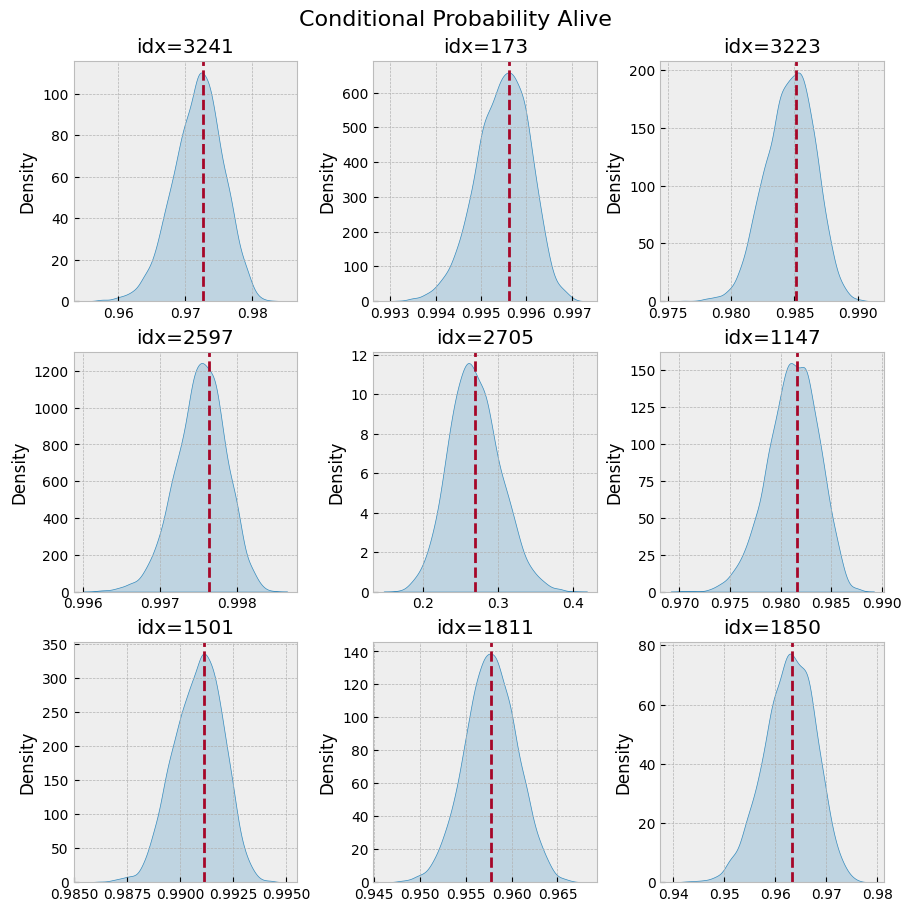

In [128]:
def plot_conditional_probability_alive(idx, ax):
    sns.kdeplot(x=p_alive_sample[idx], color="C0", fill=True, ax=ax)
    ax.axvline(x=p_alive[idx], color="C1", linestyle="--")
    ax.set(title=f"idx={idx}")
    return ax

fig, axes = plt.subplots(
    nrows=3,
    ncols=3,
    figsize=(9, 9),
    layout="constrained"
)
for ax in axes.flatten():
    idx = np.random.choice(range(n_vals))
    plot_conditional_probability_alive(idx, ax)

fig.suptitle("Conditional Probability Alive", fontsize=16)